<a href="https://colab.research.google.com/github/ctinnil/PP_Trefoil/blob/main/PP_Trefoil_POC_Case_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Privacy-Preserving Trefoil Model - SIEM POC

This project represents a Proof of concept for the Privacy-Preserving Trefoil Model, which focuses on the three central dimensions identified as vital for machine learning-based systems:
-	Data sensibility 
-	Desired model fidelity 
-	Computational cost
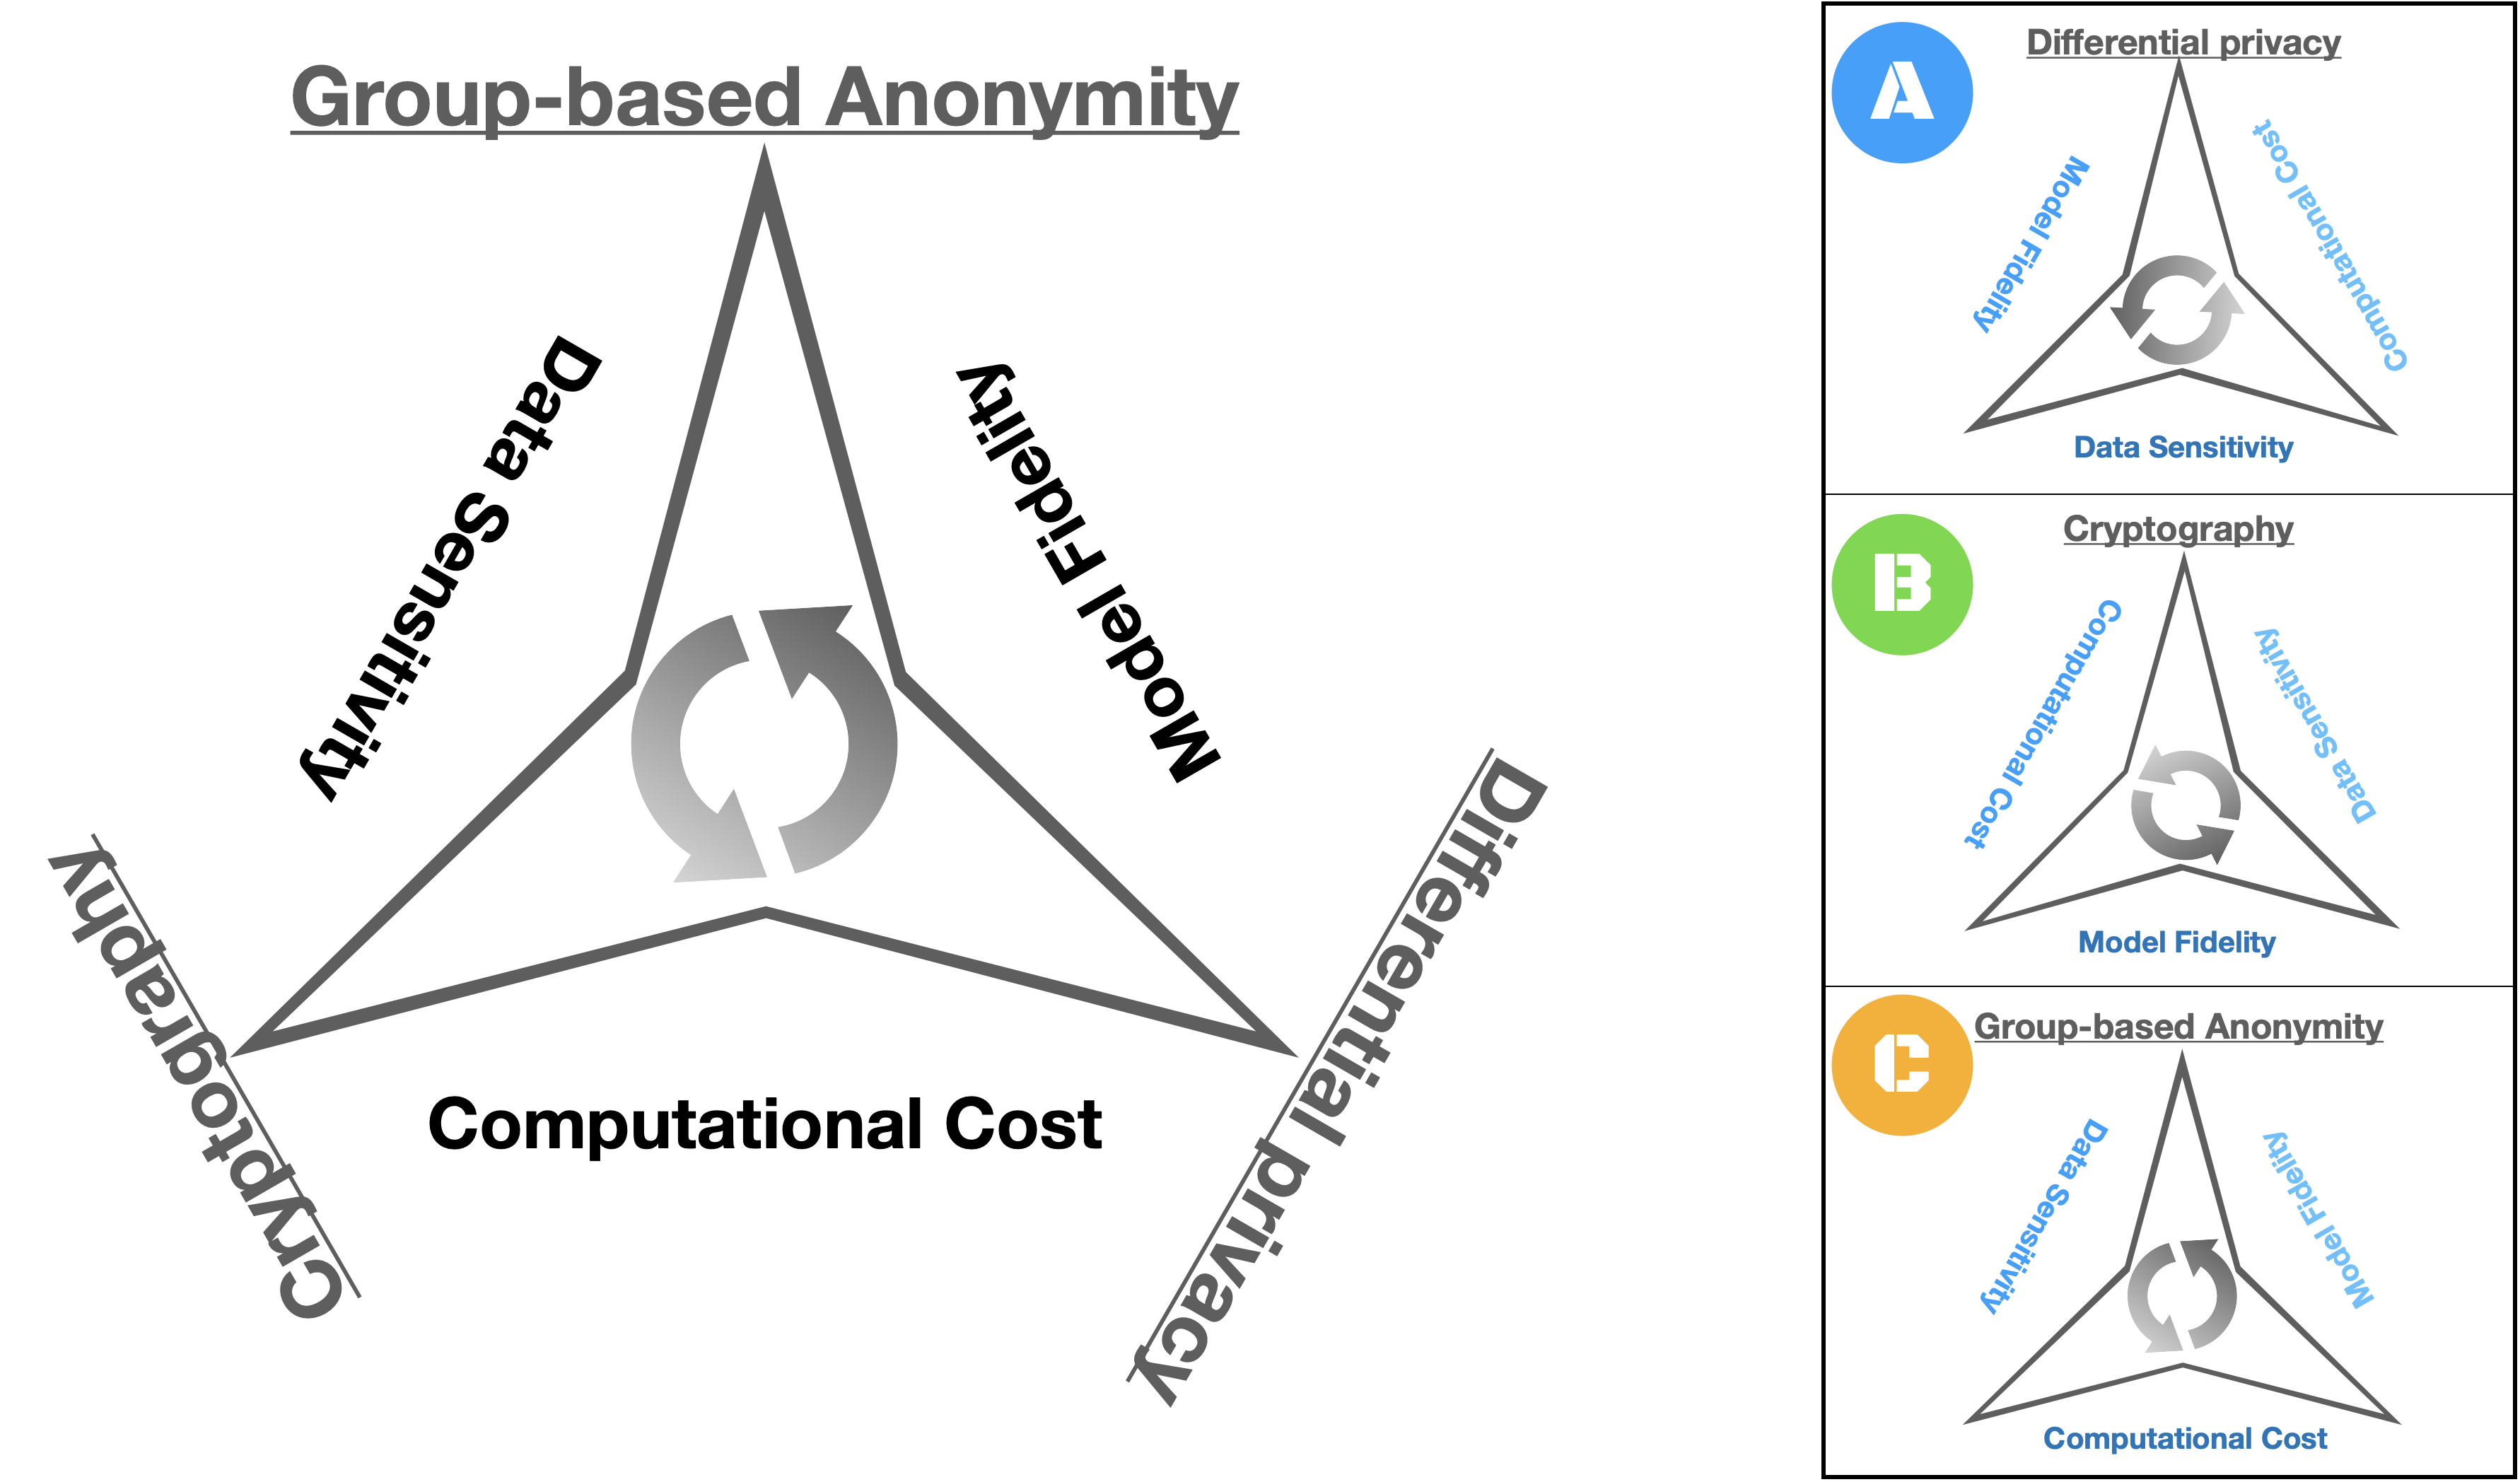

## C. Differential privacy to keep hidden sensible data

  - implemented with PyTorch
  - allows us to use Private Aggregation of Teacher Ensembles (PATE)
  - basically, we will train a Student model using the predictions of the Teacher classifiers as actual labels for our public data

## Step 1: Loading the Data

In [ ]:
import torch

from torchvision import datasets, transforms
from torch.utils.data import Subset

# Transform the image to a tensor and normalize it
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the train and test data by using the transform
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
num_teachers = 100 # Define the num of teachers
batch_size = 32 # Teacher batch size

def get_data_loaders(train_data, num_teachers):
    """ Function to create data loaders for the Teacher classifier """
    teacher_loaders = []
    data_size = len(train_data) // num_teachers
    
    for i in range(data_size):
        indices = list(range(i*data_size, (i+1)*data_size))
        subset_data = Subset(train_data, indices)
        loader = torch.utils.data.DataLoader(subset_data, batch_size=batch_size)
        teacher_loaders.append(loader)
        
    return teacher_loaders

teacher_loaders = get_data_loaders(train_data, num_teachers)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Create the public dataset by using 90% of the Test data as train #data and remaining 10% as test data.
student_train_data = Subset(test_data, list(range(9000)))
student_test_data = Subset(test_data, list(range(9000, 10000)))

student_train_loader = torch.utils.data.DataLoader(student_train_data, batch_size=batch_size)
student_test_loader = torch.utils.data.DataLoader(student_test_data, batch_size=batch_size)

## Step 2: Defining and Training the Teacher models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Classifier(nn.Module):
    """ A Simple Feed Forward Neural Network. 
        A CNN can also be used for this problem 
    """
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
def train(model, trainloader, criterion, optimizer, epochs=10):
    """ This function trains a single Classifier model """
    running_loss = 0
    for e in range(epochs):
        model.train()
        
        for images, labels in trainloader:
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
def predict(model, dataloader):
    """ This function predicts labels for a dataset 
        given the model and dataloader as inputs. 
    """
    outputs = torch.zeros(0, dtype=torch.long)
    model.eval()
    
    for images, labels in dataloader:
        output = model.forward(images)
        ps = torch.argmax(torch.exp(output), dim=1)
        outputs = torch.cat((outputs, ps))
        
    return outputs
def train_models(num_teachers):
    """ Trains *num_teacher* models (num_teachers being the number of teacher classifiers) """
    models = []
    for i in range(num_teachers):
        model = Classifier()
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.003)
        train(model, teacher_loaders[i], criterion, optimizer)
        models.append(model)
    return models
models = train_models(num_teachers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Step 3: Generate the Aggregated Teacher and Student labels by combining the predictions of the Teacher models

In [ ]:
import numpy as np

epsilon = 0.2
def aggregated_teacher(models, dataloader, epsilon):
    """ Take predictions from individual teacher model and 
        creates the true labels for the student after adding 
        laplacian noise to them 
    """
    preds = torch.torch.zeros((len(models), 9000), dtype=torch.long)
    for i, model in enumerate(models):
        results = predict(model, dataloader)
        preds[i] = results
    
    labels = np.array([]).astype(int)
    for image_preds in np.transpose(preds):
        label_counts = np.bincount(image_preds, minlength=10)
        beta = 1 / epsilon

        for i in range(len(label_counts)):
            label_counts[i] += np.random.laplace(0, beta, 1)

        new_label = np.argmax(label_counts)
        labels = np.append(labels, new_label)
    
    return preds.numpy(), labels
teacher_models = models
preds, student_labels = aggregated_teacher(teacher_models, student_train_loader, epsilon)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Step 4: Create the Student model and train it using the labels generated in step 3

In [ ]:
def student_loader(student_train_loader, labels):
    for i, (data, _) in enumerate(iter(student_train_loader)):
        yield data, torch.from_numpy(labels[i*len(data): (i+1)*len(data)])
student_model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.003)
epochs = 10
steps = 0
running_loss = 0
for e in range(epochs):
    student_model.train()
    train_loader = student_loader(student_train_loader, student_labels)
    for images, labels in train_loader:
        steps += 1
        
        optimizer.zero_grad()
        output = student_model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % 50 == 0:
            test_loss = 0
            accuracy = 0
            student_model.eval()
            with torch.no_grad():
                for images, labels in student_test_loader:
                    log_ps = student_model(images)
                    test_loss += criterion(log_ps, labels).item()
                    
                    # Accuracy
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            student_model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(student_train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(student_test_loader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(student_test_loader)))
            running_loss = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/10..  Training Loss: 0.332..  Test Loss: 0.900..  Test Accuracy: 0.735
Epoch: 1/10..  Training Loss: 0.172..  Test Loss: 0.515..  Test Accuracy: 0.857
Epoch: 1/10..  Training Loss: 0.120..  Test Loss: 0.389..  Test Accuracy: 0.882
Epoch: 1/10..  Training Loss: 0.089..  Test Loss: 0.403..  Test Accuracy: 0.880
Epoch: 1/10..  Training Loss: 0.090..  Test Loss: 0.268..  Test Accuracy: 0.928
Epoch: 2/10..  Training Loss: 0.148..  Test Loss: 0.520..  Test Accuracy: 0.916
Epoch: 2/10..  Training Loss: 0.104..  Test Loss: 0.256..  Test Accuracy: 0.932
Epoch: 2/10..  Training Loss: 0.081..  Test Loss: 0.243..  Test Accuracy: 0.933
Epoch: 2/10..  Training Loss: 0.075..  Test Loss: 0.229..  Test Accuracy: 0.931
Epoch: 2/10..  Training Loss: 0.051..  Test Loss: 0.230..  Test Accuracy: 0.940
Epoch: 2/10..  Training Loss: 0.057..  Test Loss: 0.216..  Test Accuracy: 0.937
Epoch: 3/10..  Training Loss: 0.122..  Test Loss: 0.249..  Test Accuracy: 0.927
Epoch: 3/10..  Training Loss: 0.082..  T

## Step 5: Let’s Perform PATE Analysis on the student labels generated by the Aggregated Teacher

In [ ]:
#!pip install syft==0.1.21a1

from syft.frameworks.torch.differential_privacy import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=student_labels, noise_eps=epsilon, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 1451.5129254649705
Data Dependent Epsilon: 3.685824270611866


# References

https://towardsdatascience.com/a-5-step-guide-on-incorporating-differential-privacy-into-your-deep-learning-models-7861c6c822c4